In [24]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [25]:
SCALE = 2
SHIFT = (-5, -4)
MAP_VERTICES = (
    np.array(
        [
            (-2, 0),
            (11, 0),
            (11, -3),
            (14, -4),
            (17, -4),
            (20, -2.5),
            (20, 8),
            (17, 8),
            (17, 13),
            (13, 13),
            (13, 9),
            (4, 9),
            (4, 6),
            (-2, 6),
            (-2, 0),
        ]
    )
    * SCALE
    + SHIFT
)

SIGNAL_SOURCE_POS = np.array([25.0, 5.0])

In [26]:
# Read the CSV
df = pd.read_csv("patrol_data.csv")

# Group by cell and robot, and extract waypoints
patrol_data = {}

for (cell_id, robot_id), group in df.groupby(["cell_id", "robot_id"]):
    waypoints = group[["x", "y"]].to_numpy()
    
    if cell_id not in patrol_data:
        patrol_data[cell_id] = []

    patrol_data[cell_id].append(waypoints)
    
df.head()

,cell_id,robot_id,x,y
0,0,0,2.292630,3.009131
1,0,0,6.185911,-1.396899
2,0,0,0.423536,-2.565565
3,0,0,2.292630,3.009131
4,0,1,-7.392990,3.696094


In [27]:
df = pd.read_csv("simulation_data.csv")

df.head()

,cell_id,robot_id,x,y,strength
0,0,0,2.292630,3.009131,-0.594508
1,0,0,2.358846,2.934195,-0.594508
2,0,0,2.425061,2.859258,-0.584826
3,0,0,2.491277,2.784322,-0.575438
4,0,0,2.557493,2.709385,-0.566347


In [28]:
robot_data = {
    robot_id: group[["x", "y", "strength"]]
    for robot_id, group in df.groupby("robot_id")
}

# Example: Access data for robot_id 0
print(robot_data[0])

              x         y  strength
0      2.292630  3.009131 -0.594508
1      2.358846  2.934195 -0.594508
2      2.425061  2.859258 -0.584826
3      2.491277  2.784322 -0.575438
4      2.557493  2.709385 -0.566347
...         ...       ...       ...
1583  30.254246  9.661265 -2.521766
1584  30.291496  9.754069 -2.532748
1585  30.328745  9.846872 -2.543811
1586  30.383123  9.982352 -2.554953
1587  30.383123  9.982352 -2.571358

[703 rows x 3 columns]


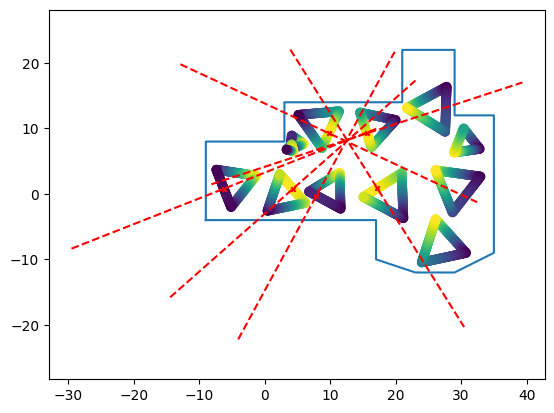

In [35]:
fig, ax = plt.subplots()
ax.plot(MAP_VERTICES[:, 0], MAP_VERTICES[:, 1])
# ax.scatter(SIGNAL_SOURCE_POS[0], SIGNAL_SOURCE_POS[1], marker="x", color="blue", s=50)

for cell_id, cell_group in df.groupby("cell_id"):
    
    for robot_id, robot in cell_group.groupby("robot_id"):
        
        ax.scatter(robot["x"], robot["y"], c=robot["strength"], cmap="viridis")

        vertices = patrol_data[cell_id][robot_id]

        for i in range(len(vertices) - 1):  # closed loop assumed
            start_x, start_y = vertices[i]
            end_x, end_y = vertices[i + 1]

            # Match start and end vertices
            start_match = robot[
                np.isclose(robot["x"], start_x) & np.isclose(robot["y"], start_y)
            ]
            end_match = robot[
                np.isclose(robot["x"], end_x) & np.isclose(robot["y"], end_y)
            ]

            if not start_match.empty and not end_match.empty:
                
                if i == 0:
                    start_idx = start_match.index[0]
                else:
                    start_idx = start_match.index[-1]
                end_idx = end_match.index[-1]

                i1, i2 = sorted([start_idx, end_idx])
                df_split = robot.loc[i1:i2]

                max_strength_row = df_split.loc[df_split["strength"].idxmax()]

                # Skip if max point is at vertex
                if not (
                    (np.isclose(max_strength_row["x"], start_x) and np.isclose(max_strength_row["y"], start_y))
                    or
                    (np.isclose(max_strength_row["x"], end_x) and np.isclose(max_strength_row["y"], end_y))
                ) and max_strength_row["strength"] >= -100:
                    ax.scatter(
                        max_strength_row["x"],
                        max_strength_row["y"],
                        marker="x",
                        color="r",
                        s=10,
                    )

                    # Calculate gradient of segment
                    dx = end_x - start_x
                    dy = end_y - start_y
                    gradient = np.inf if np.isclose(dx, 0.0) else dy / dx

                    # Perpendicular gradient
                    if np.isclose(gradient, 0.0):
                        perp_grad = np.inf
                    elif np.isinf(gradient):
                        perp_grad = 0.0
                    else:
                        perp_grad = -1 / gradient

                    # Line through max point with gradient = perp_grad
                    length = 50.0  # adjustable
                    x0, y0 = max_strength_row["x"], max_strength_row["y"]

                    if np.isinf(perp_grad):
                        x_vals = [x0, x0]
                        y_vals = [y0 - length / 2, y0 + length / 2]
                    else:
                        dx_line = length / 2 / np.sqrt(1 + perp_grad**2)
                        x_vals = [x0 - dx_line, x0 + dx_line]
                        y_vals = [perp_grad * (x - x0) + y0 for x in x_vals]

                    ax.plot(x_vals, y_vals, "r--")

            else:
                print(f"Segment skipped: no match for robot {robot_id} in cell {cell_id}, segment {i}")

ax.axis("equal")
plt.show()